# Reconocimiento de Instrumento Principal en una Señal de Audio

Este notebook busca desarrollar un algoritmo para detectar el instrumento principal en una señal de audio.

## El Dataset

Será usado el IRMAS Dataset (https://www.upf.edu/web/mtg/irmas).

El dataset se divide en datos de entrenamiento y prueba.

### Datos de entrenamiento

**Archivos de audio:** 6705 archivos de audio en formato wav estéreo de 16 bits muestreados a 44.1kHz. Son extractos de 3 segundos de más de 2000 grabaciones distintas.

**Anotaciones:** la indicación del instrumento predominante de cada extracto está tanto en el nombre de la carpeta contenedora como en el nombre del archivo: cello (cel), clarinete (cla), flauta (flu), guitarra acústica (gac), guitarra eléctrica (gel), órgano (org), piano (pia), saxofón (sax), trompeta (tru), violín (vio) y voz humana (voi). El número de archivos por instrumento es: cel(388), cla(505), flu(451), gac(637), gel(760), org(682), pia(721), sax(626), tru(577), vio(580), voi(778).

Además, algunos de los archivos tienen una anotación en el nombre del archivo con respecto a la presencia ([dru]) o no presencia ([nod]) de la batería, y el género musical: country-folk ([cou_fol]), classical ([cla]) , pop-rock ([pop-roc]), latin-soul ([lat-sou]).

El dataset incluye música actual y del siglo pasado, por lo que se percibe la difierecia en la calidad de audio de algunos extractos. Además, abarca una gran variabilidad en los tipos de instrumentos musicales, intérpretes, articulaciones, así como estilos generales de grabación y producción. Además, tratamos de maximizar la distribución de los géneros musicales dentro de la colección para evitar la extracción de información relacionada con las características del género. Se pagó a dos estudiantes para obtener los datos de 11 instrumentos de las pistas de música preseleccionadas, con el objetivo de extraer extractos que contengan una presencia continua de un único instrumento de destino predominante. Por lo tanto, no se permitió asignar más de un instrumento a un extracto dado.

### Datos de prueba

**Audio:** 2874 extractos en formato wav estéreo de 16 bits muestreados a 44.1kHz.

**Archivos de anotación:** Las anotaciones para un extracto llamado: "excerptName.wav" se dan en "excerptName.txt". Se puede anotar más de un instrumento en cada extracto, una etiqueta por línea.

# Empecemos con el notebook!

# Imports iniciales

In [1]:
# Preaparando los imports
import os
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import pandas as pd
import keras

Using TensorFlow backend.


# Preparacion del Dataset

In [2]:
# Prueba de lectura
rate, data = wav.read("C:/Users/pedri/Downloads/IRMAS-Sample/Training/sax/118__[sax][nod][jaz_blu]1702__3.wav")

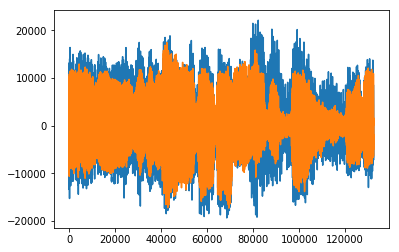

In [3]:
%matplotlib inline
plt.plot(data)
plt.show()

**Nota:** La señal es stereo... Luego observo si esto tiene algún impacto

In [4]:
# Probando la lectura de varios archivos

base_directory = "./IRMAS-TrainingData/"

for path, dirs, files in os.walk(base_directory):
    for filename in files:
        s = path.split("/")[-1]
        print(s)
        print(os.path.join(path, filename))

cel
./IRMAS-TrainingData/cel\008__[cel][nod][cla]0058__1.wav
cel
./IRMAS-TrainingData/cel\008__[cel][nod][cla]0058__2.wav
cel
./IRMAS-TrainingData/cel\008__[cel][nod][cla]0058__3.wav
cel
./IRMAS-TrainingData/cel\012__[cel][nod][cla]0043__1.wav
cel
./IRMAS-TrainingData/cel\012__[cel][nod][cla]0043__2.wav
cel
./IRMAS-TrainingData/cel\012__[cel][nod][cla]0043__3.wav
cel
./IRMAS-TrainingData/cel\013__[cel][nod][cla]0025__1.wav
cel
./IRMAS-TrainingData/cel\013__[cel][nod][cla]0025__2.wav
cel
./IRMAS-TrainingData/cel\013__[cel][nod][cla]0025__3.wav
cel
./IRMAS-TrainingData/cel\014__[cel][nod][cla]0041__1.wav
cel
./IRMAS-TrainingData/cel\014__[cel][nod][cla]0041__2.wav
cel
./IRMAS-TrainingData/cel\014__[cel][nod][cla]0041__3.wav
cel
./IRMAS-TrainingData/cel\027__[cel][nod][cla]0027__1.wav
cel
./IRMAS-TrainingData/cel\027__[cel][nod][cla]0027__2.wav
cel
./IRMAS-TrainingData/cel\027__[cel][nod][cla]0027__3.wav
cel
./IRMAS-TrainingData/cel\031__[cel][nod][cla]0020__1.wav
cel
./IRMAS-TrainingData

./IRMAS-TrainingData/flu\[flu][cla]0361__3.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0362__1.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0362__2.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0362__3.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0363__1.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0363__2.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0363__3.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0366__1.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0366__2.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0366__3.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0367__1.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0367__2.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0367__3.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0368__1.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0368__2.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0368__3.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0369__1.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0369__2.wav
flu
./IRMAS-TrainingData/flu\[flu][cla]0369__3.wav
flu
./IRMAS-TrainingData/flu\[flu][

./IRMAS-TrainingData/gac\[gac][cla]0667__1.wav
gac
./IRMAS-TrainingData/gac\[gac][cla]0667__2.wav
gac
./IRMAS-TrainingData/gac\[gac][cla]0667__3.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0523__1.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0523__2.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0523__3.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0524__1.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0524__2.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0524__3.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0531__1.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0531__2.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0531__3.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0532__1.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0532__2.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0532__3.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0535__1.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0535__2.wav
gac
./IRMAS-TrainingData/gac\[gac][jaz_blu]0535__3.wav
gac
./IRMAS-TrainingData/g

./IRMAS-TrainingData/gel\[gel][jaz_blu]0996__1.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0996__2.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0996__3.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0997__1.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0997__2.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0997__3.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0998__1.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0998__2.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0998__3.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0999__1.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0999__2.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]0999__3.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]1000__1.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]1000__2.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]1000__3.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]1001__1.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]1001__2.wav
gel
./IRMAS-TrainingData/gel\[gel][jaz_blu]1001__3.wav
gel
./IRMAS-Tr

org
./IRMAS-TrainingData/org\[org][pop_roc]1127__1.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1127__2.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1127__3.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1128__1.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1128__2.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1128__3.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1129__1.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1129__2.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1130__1.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1130__2.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1130__3.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1131__1.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1131__2.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1131__3.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1132__1.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1132__2.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1132__3.wav
org
./IRMAS-TrainingData/org\[org][pop_roc]1133__1.wav
org
./IRMA

./IRMAS-TrainingData/pia\[pia][jaz_blu]1520__3.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1521__1.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1521__2.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1521__3.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1522__1.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1522__2.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1522__3.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1523__1.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1523__2.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1523__3.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1524__1.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1524__2.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1524__3.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1525__1.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1525__2.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1525__3.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1526__1.wav
pia
./IRMAS-TrainingData/pia\[pia][jaz_blu]1526__2.wav
pia
./IRMAS-Tr

./IRMAS-TrainingData/sax\[sax][pop_roc]1622__1.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1622__2.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1622__3.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1623__1.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1623__2.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1623__3.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1626__1.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1626__2.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1626__3.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1627__1.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1627__2.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1627__3.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1628__1.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1628__2.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1628__3.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1629__1.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1629__2.wav
sax
./IRMAS-TrainingData/sax\[sax][pop_roc]1629__3.wav
sax
./IRMAS-Tr

./IRMAS-TrainingData/vio\050__[vio][nod][cla]2155__1.wav
vio
./IRMAS-TrainingData/vio\050__[vio][nod][cla]2155__2.wav
vio
./IRMAS-TrainingData/vio\050__[vio][nod][cla]2155__3.wav
vio
./IRMAS-TrainingData/vio\058__[vio][nod][cla]2174__1.wav
vio
./IRMAS-TrainingData/vio\058__[vio][nod][cla]2174__2.wav
vio
./IRMAS-TrainingData/vio\058__[vio][nod][cla]2174__3.wav
vio
./IRMAS-TrainingData/vio\064__[vio][nod][cou_fol]2187__1.wav
vio
./IRMAS-TrainingData/vio\064__[vio][nod][cou_fol]2187__2.wav
vio
./IRMAS-TrainingData/vio\072__[vio][dru][cou_fol]2188__1.wav
vio
./IRMAS-TrainingData/vio\072__[vio][dru][cou_fol]2188__2.wav
vio
./IRMAS-TrainingData/vio\072__[vio][dru][cou_fol]2188__3.wav
vio
./IRMAS-TrainingData/vio\074__[vio][nod][cla]2159__1.wav
vio
./IRMAS-TrainingData/vio\074__[vio][nod][cla]2159__2.wav
vio
./IRMAS-TrainingData/vio\074__[vio][nod][cla]2159__3.wav
vio
./IRMAS-TrainingData/vio\077__[vio][nod][cla]2166__1.wav
vio
./IRMAS-TrainingData/vio\077__[vio][nod][cla]2166__2.wav
vio
./IR

voi
./IRMAS-TrainingData/voi\031__[voi][dru][cou_fol]2395__1.wav
voi
./IRMAS-TrainingData/voi\031__[voi][dru][cou_fol]2395__2.wav
voi
./IRMAS-TrainingData/voi\031__[voi][dru][cou_fol]2395__3.wav
voi
./IRMAS-TrainingData/voi\033__[voi][nod][pop_roc]2467__1.wav
voi
./IRMAS-TrainingData/voi\033__[voi][nod][pop_roc]2467__2.wav
voi
./IRMAS-TrainingData/voi\033__[voi][nod][pop_roc]2467__3.wav
voi
./IRMAS-TrainingData/voi\034__[voi][nod][cou_fol]2379__1.wav
voi
./IRMAS-TrainingData/voi\034__[voi][nod][cou_fol]2379__2.wav
voi
./IRMAS-TrainingData/voi\034__[voi][nod][cou_fol]2379__3.wav
voi
./IRMAS-TrainingData/voi\035__[voi][nod][cou_fol]2437__1.wav
voi
./IRMAS-TrainingData/voi\035__[voi][nod][cou_fol]2437__2.wav
voi
./IRMAS-TrainingData/voi\035__[voi][nod][cou_fol]2437__3.wav
voi
./IRMAS-TrainingData/voi\037__[voi][dru][pop_roc]2473__1.wav
voi
./IRMAS-TrainingData/voi\037__[voi][dru][pop_roc]2473__2.wav
voi
./IRMAS-TrainingData/voi\037__[voi][dru][pop_roc]2473__3.wav
voi
./IRMAS-TrainingData/

In [5]:
# Preparar el dataset
instrument_encoding = {
    "cel": 0, 
    "cla": 1, 
    "flu": 2, 
    "gac": 3, 
    "gel": 4, 
    "org": 5, 
    "pia": 6,
    "sax": 7, 
    "tru": 8,
    "vio": 9, 
    "voi": 10
}

start_dir = "./IRMAS-TrainingData/"

dataset = list()

for path, dirs, files in os.walk(start_dir):
    for filename in files:
        row = dict()
        instrument = path.split("/")[-1]
        rate, audio_signal = wav.read(os.path.join(path, filename))
        row["instrument"] = instrument_encoding[instrument]
        row["audio"] = audio_signal
        dataset.append(row)

training_data = pd.DataFrame(dataset)

In [6]:
training_data.head(10)

,audio,instrument
0,"[[-82, 30], [-73, 40], [-62, 49], [-49, 58], [...",0
1,"[[30, 46], [22, 41], [17, 36], [10, 26], [10, ...",0
2,"[[-247, -303], [-224, -294], [-200, -296], [-1...",0
3,"[[-329, 363], [-363, 268], [-423, 174], [-494,...",0
4,"[[28, -596], [-40, -596], [-69, -620], [-189, ...",0
5,"[[814, 337], [877, 442], [884, 410], [866, 239...",0
6,"[[-194, -79], [-158, -45], [-119, -3], [-148, ...",0
7,"[[1113, 1160], [1162, 1205], [1182, 1207], [11...",0
8,"[[-2070, -2096], [-2057, -2088], [-1855, -1910...",0
9,"[[1152, 349], [1213, 489], [1242, 596], [1200,...",0


In [7]:
print(training_data.dtypes)

audio         object
instrument     int64
dtype: object


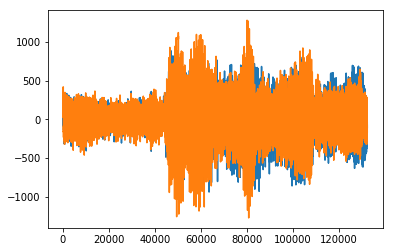

In [8]:
%matplotlib inline
plt.plot(training_data['audio'][0])
plt.show()

**Nota:** Lista la carga de archivos "básica", todavía hace falta estudiar si hacen falta parametros del filename

### One-hot encoding para las salidas

In [9]:
# Specifying the length of the array
num_classes = len(instrument_encoding)

# One-hot!
y_train = keras.utils.to_categorical(training_data['instrument'], num_classes)

In [10]:
# Validating the one-hot encoding
y_train.shape

# The result should be (# of training examples, # of instruments)

(6705, 11)

### Preparando las entradas 

In [11]:
# Getting the training inputs
x_train = training_data['audio']

In [12]:
# Validate the training inputs
print(x_train.shape)

# Remeber we are using stereo signals
print(x_train[0].shape)

(6705,)
(132299, 2)


## Primer problema...

Las salidas no están aptas para las entradas a una CNN...

Luego de un poco de investiogación, conseguí un paquete de Python recomendado para el manejo de data de audio para el anáñisis de audio y _música_. Ese paquete es **librosa**.

## Librosa
(https://github.com/librosa/librosa)

Esta librería esta bastante respaldada por la comunidad de análisis de señales de audio y música. Algunas de las cosas interesantes que ofrece son:

* Manejo del IO de audio.
* Algoritmos de DSP.
* Visualización de señales de audio, en tiempo y frecuencia.
* Extranción de _features_ de audio (spectrogramas y chromagramas).
* Determinación del _tempo_.
* Filtros y efectos musicales.
* Etc...

Por lo tanto, decido seguir con la recomendación de la comunidad y usar esta librería para el manejo del dataset de audio.


# Preparando el dataset usando librosa

In [35]:
# Imports for the dataset
import librosa
import librosa.display
import librosa.feature

In [29]:
# Some tests
data, sample_rate = librosa.load("C:/Users/pedri/Downloads/IRMAS-Sample/Training/sax/118__[sax][nod][jaz_blu]1702__3.wav")

Populating the interactive namespace from numpy and matplotlib


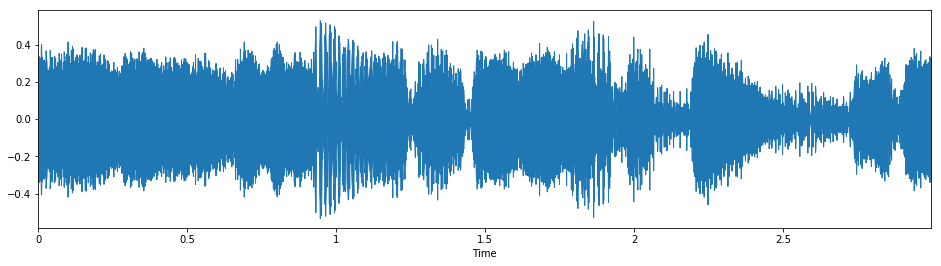

In [30]:
%pylab inline
plt.figure(figsize=(16, 4))
librosa.display.waveplot(data, sr=sample_rate)

In [31]:
# Dataset read function
start_dir = "./IRMAS-TrainingData/"

def read_audio_dataset(start_directory):
    start_dir = start_directory
    dataset = list()
    for path, dirs, files in os.walk(start_dir):
        for filename in files:
            row = dict()
            instrument = path.split("/")[-1]
            row["instrument"] = instrument_encoding[instrument]
            row["audio_file"] = os.path.join(path, filename)
            dataset.append(row)
    return dataset

In [34]:
# Loadning the dataset

dataset = pd.DataFrame(read_audio_dataset(start_dir))

dataset.head(10)

,audio_file,instrument
0,./IRMAS-TrainingData/cel\008__[cel][nod][cla]0...,0
1,./IRMAS-TrainingData/cel\008__[cel][nod][cla]0...,0
2,./IRMAS-TrainingData/cel\008__[cel][nod][cla]0...,0
3,./IRMAS-TrainingData/cel\012__[cel][nod][cla]0...,0
4,./IRMAS-TrainingData/cel\012__[cel][nod][cla]0...,0
5,./IRMAS-TrainingData/cel\012__[cel][nod][cla]0...,0
6,./IRMAS-TrainingData/cel\013__[cel][nod][cla]0...,0
7,./IRMAS-TrainingData/cel\013__[cel][nod][cla]0...,0
8,./IRMAS-TrainingData/cel\013__[cel][nod][cla]0...,0
9,./IRMAS-TrainingData/cel\014__[cel][nod][cla]0...,0


In [41]:
# Preapring a parser

def parser(row):
    num_mfcc = 40
   # function to load files and extract features
    file_name = row['audio_file']

   # handle exception to check if there isn't a file which is corrupted
   try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_mfcc).T,axis=0) 
   except Exception as e:
      print("Error encountered while parsing file: ", file)
      return None, None
 
   feature = mfccs
   instrument = row['instrument']
 
   return [feature, instrument]

In [47]:
# Create the dataset
train = dataset.apply(parser, axis=1)

In [50]:
# Fixing the columns name
train.columns = ['feature', 'instrument']
train.head(10)

,feature,instrument
0,"[-504.139434973, 146.599657138, -29.1971492038...",0
1,"[-450.837263914, 132.518278686, -31.9897767804...",0
2,"[-404.966760666, 121.834832995, -37.6514889456...",0
3,"[-317.247056649, 135.267460654, -29.4179305056...",0
4,"[-311.622976115, 125.683183809, -32.9319603227...",0
5,"[-297.162067147, 113.015259088, -38.260997353,...",0
6,"[-302.339151003, 135.015977194, -32.4488141208...",0
7,"[-308.820472202, 148.06053619, -30.6829171531,...",0
8,"[-287.93103379, 133.258676304, -47.8903762317,...",0
9,"[-276.066085, 121.044045867, -29.8171406129, 3...",0


In [54]:
x_train = np.array(train.feature.tolist())
y_train = np.array(y_train) #It's one-hot encoded

In [55]:
print(x_train)

[[ -5.04139435e+02   1.46599657e+02  -2.91971492e+01 ...,   8.15606862e-02
    1.29126785e+01   7.80531772e+00]
 [ -4.50837264e+02   1.32518279e+02  -3.19897768e+01 ...,   7.10623198e+00
    8.69896560e+00  -7.03010772e+00]
 [ -4.04966761e+02   1.21834833e+02  -3.76514889e+01 ...,  -6.26233206e+00
   -5.23859739e+00   7.30058242e+00]
 ..., 
 [ -1.01461335e+02   9.22021514e+01  -1.08791366e+01 ...,   9.86610883e-01
   -2.27960828e+00  -9.86414921e-01]
 [ -9.42292481e+01   7.42597373e+01  -2.15292886e+01 ...,   7.05760130e-01
   -2.20508299e-01   9.50188862e+00]
 [ -6.58043674e+01   9.56851030e+01  -3.48557838e+01 ...,   3.30890282e+00
   -3.80262576e-01   2.31345196e+00]]


In [53]:
print(y_train)

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


# Preparemos la CNN

**Nota:** El data set es de archivos de audio en **stereo** por lo tanto es necesario validar 2 cosas:
1. ¿Es mejor usar _features_ y una NN Densa?
2. ¿Resultaría conveniente transformar los archivo de stereo a mono?

#### Busquemos respuestas!

### Imports para C/NN

In [56]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D

In [64]:
def build_NN_model(num_instruments):
    model = Sequential()
    model.add(Dense(2560, input_shape=(40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_instruments))
    model.add(Activation('softmax'))
    return model

In [65]:
nn_model = build_NN_model(y_train.shape[1])
nn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Listo para entrenar!

In [67]:
# Preparing the cool graphics helper
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_test, y_val_categorical=y_test)

# Training
nn_model.fit(x_train, y_train, batch_size=32, epochs=300)

Epoch 1/2000
6705/6705 [==============================] - 4s 602us/step - loss: 2.2387 - acc: 0.2122
Epoch 2/2000
6705/6705 [==============================] - 4s 584us/step - loss: 2.2267 - acc: 0.2182
Epoch 3/2000
6705/6705 [==============================] - 4s 632us/step - loss: 2.2090 - acc: 0.2195
Epoch 4/2000
6705/6705 [==============================] - 4s 611us/step - loss: 2.1995 - acc: 0.2382
Epoch 5/2000
6705/6705 [==============================] - 5s 691us/step - loss: 2.1892 - acc: 0.2368
Epoch 6/2000
6705/6705 [==============================] - 4s 651us/step - loss: 2.1600 - acc: 0.2467
Epoch 7/2000
6705/6705 [==============================] - 4s 631us/step - loss: 2.1469 - acc: 0.2503
Epoch 8/2000
6705/6705 [==============================] - 5s 719us/step - loss: 2.1288 - acc: 0.2698
Epoch 9/2000
6705/6705 [==============================] - 5s 697us/step - loss: 2.1136 - acc: 0.2764
Epoch 10/2000
6705/6705 [==============================] - 4s 615us/step - loss: 2.1096 - a

6705/6705 [==============================] - 4s 647us/step - loss: 1.1702 - acc: 0.6081
Epoch 81/2000
6705/6705 [==============================] - 4s 595us/step - loss: 1.1463 - acc: 0.6152
Epoch 82/2000
6705/6705 [==============================] - 4s 614us/step - loss: 1.1726 - acc: 0.6118
Epoch 83/2000
6705/6705 [==============================] - 4s 665us/step - loss: 1.1252 - acc: 0.6260
Epoch 84/2000
6705/6705 [==============================] - 5s 714us/step - loss: 1.1277 - acc: 0.6277 1s - lo
Epoch 85/2000
6705/6705 [==============================] - 5s 709us/step - loss: 1.1181 - acc: 0.6258
Epoch 86/2000
6705/6705 [==============================] - 4s 669us/step - loss: 1.1143 - acc: 0.6294
Epoch 87/2000
6705/6705 [==============================] - 5s 686us/step - loss: 1.1202 - acc: 0.6280
Epoch 88/2000
6705/6705 [==============================] - 4s 620us/step - loss: 1.1373 - acc: 0.6198
Epoch 89/2000
6705/6705 [==============================] - 4s 625us/step - loss: 1.0989 

6705/6705 [==============================] - 5s 688us/step - loss: 0.8590 - acc: 0.7196 3s - 
Epoch 160/2000
6705/6705 [==============================] - 5s 706us/step - loss: 0.8643 - acc: 0.7226
Epoch 161/2000
6705/6705 [==============================] - 5s 699us/step - loss: 0.8176 - acc: 0.7326
Epoch 162/2000
6705/6705 [==============================] - 5s 684us/step - loss: 0.8535 - acc: 0.7241
Epoch 163/2000
6705/6705 [==============================] - 5s 691us/step - loss: 0.8212 - acc: 0.7280 1s 
Epoch 164/2000
6705/6705 [==============================] - 5s 677us/step - loss: 0.8817 - acc: 0.7198
Epoch 165/2000
6705/6705 [==============================] - 5s 723us/step - loss: 0.8317 - acc: 0.7280
Epoch 166/2000
6705/6705 [==============================] - 5s 767us/step - loss: 0.8444 - acc: 0.7262
Epoch 167/2000
6705/6705 [==============================] - 4s 634us/step - loss: 0.8274 - acc: 0.7335
Epoch 168/2000
6705/6705 [==============================] - 4s 617us/step - lo

6705/6705 [==============================] - 4s 551us/step - loss: 0.7167 - acc: 0.7781
Epoch 238/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.6960 - acc: 0.7802
Epoch 239/2000
6705/6705 [==============================] - 4s 568us/step - loss: 0.7043 - acc: 0.7729
Epoch 240/2000
6705/6705 [==============================] - 4s 610us/step - loss: 0.7196 - acc: 0.7672
Epoch 241/2000
6705/6705 [==============================] - 4s 610us/step - loss: 0.7299 - acc: 0.7723
Epoch 242/2000
6705/6705 [==============================] - 4s 583us/step - loss: 0.6944 - acc: 0.7760
Epoch 243/2000
6705/6705 [==============================] - 4s 630us/step - loss: 0.7098 - acc: 0.7738
Epoch 244/2000
6705/6705 [==============================] - 4s 569us/step - loss: 0.7302 - acc: 0.7730
Epoch 245/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.7257 - acc: 0.7770
Epoch 246/2000
6705/6705 [==============================] - 4s 578us/step - loss: 0.6957

6705/6705 [==============================] - 5s 675us/step - loss: 0.6376 - acc: 0.7963
Epoch 317/2000
6705/6705 [==============================] - 5s 714us/step - loss: 0.6667 - acc: 0.7961
Epoch 318/2000
6705/6705 [==============================] - 4s 651us/step - loss: 0.6668 - acc: 0.8015
Epoch 319/2000
6705/6705 [==============================] - 5s 673us/step - loss: 0.6577 - acc: 0.7958
Epoch 320/2000
6705/6705 [==============================] - 4s 598us/step - loss: 0.6431 - acc: 0.8033
Epoch 321/2000
6705/6705 [==============================] - 4s 607us/step - loss: 0.6452 - acc: 0.8036
Epoch 322/2000
6705/6705 [==============================] - 4s 658us/step - loss: 0.6379 - acc: 0.8037
Epoch 323/2000
6705/6705 [==============================] - 4s 602us/step - loss: 0.6265 - acc: 0.8089
Epoch 324/2000
6705/6705 [==============================] - 4s 594us/step - loss: 0.6241 - acc: 0.8055
Epoch 325/2000
6705/6705 [==============================] - 4s 613us/step - loss: 0.6502

6705/6705 [==============================] - 4s 563us/step - loss: 0.5712 - acc: 0.8264
Epoch 396/2000
6705/6705 [==============================] - 4s 551us/step - loss: 0.5821 - acc: 0.8234
Epoch 397/2000
6705/6705 [==============================] - 4s 551us/step - loss: 0.6093 - acc: 0.8188
Epoch 398/2000
6705/6705 [==============================] - 4s 559us/step - loss: 0.6032 - acc: 0.8200
Epoch 399/2000
6705/6705 [==============================] - 4s 554us/step - loss: 0.6132 - acc: 0.8207
Epoch 400/2000
6705/6705 [==============================] - 4s 550us/step - loss: 0.5856 - acc: 0.8260
Epoch 401/2000
6705/6705 [==============================] - 4s 551us/step - loss: 0.5893 - acc: 0.8227
Epoch 402/2000
6705/6705 [==============================] - 4s 553us/step - loss: 0.6024 - acc: 0.8210
Epoch 403/2000
6705/6705 [==============================] - 4s 555us/step - loss: 0.5934 - acc: 0.8215
Epoch 404/2000
6705/6705 [==============================] - 4s 579us/step - loss: 0.5996

6705/6705 [==============================] - 4s 615us/step - loss: 0.5647 - acc: 0.8282
Epoch 475/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.5599 - acc: 0.8336
Epoch 476/2000
6705/6705 [==============================] - 4s 631us/step - loss: 0.5921 - acc: 0.8261
Epoch 477/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.5906 - acc: 0.8330
Epoch 478/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.5785 - acc: 0.8236
Epoch 479/2000
6705/6705 [==============================] - 4s 648us/step - loss: 0.5577 - acc: 0.8330
Epoch 480/2000
6705/6705 [==============================] - 4s 651us/step - loss: 0.5690 - acc: 0.8289
Epoch 481/2000
6705/6705 [==============================] - 4s 641us/step - loss: 0.5859 - acc: 0.8245
Epoch 482/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5832 - acc: 0.8289
Epoch 483/2000
6705/6705 [==============================] - 4s 625us/step - loss: 0.5549

6705/6705 [==============================] - 4s 635us/step - loss: 0.5779 - acc: 0.8358
Epoch 554/2000
6705/6705 [==============================] - 4s 628us/step - loss: 0.5168 - acc: 0.8467
Epoch 555/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.5219 - acc: 0.8462
Epoch 556/2000
6705/6705 [==============================] - 4s 612us/step - loss: 0.5279 - acc: 0.8455
Epoch 557/2000
6705/6705 [==============================] - 4s 612us/step - loss: 0.5291 - acc: 0.8412
Epoch 558/2000
6705/6705 [==============================] - 4s 624us/step - loss: 0.5310 - acc: 0.8473
Epoch 559/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.5599 - acc: 0.8403
Epoch 560/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.5732 - acc: 0.8404
Epoch 561/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.5616 - acc: 0.8370
Epoch 562/2000
6705/6705 [==============================] - 4s 625us/step - loss: 0.5731

6705/6705 [==============================] - 4s 613us/step - loss: 0.5514 - acc: 0.8422
Epoch 633/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.5448 - acc: 0.8449
Epoch 634/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.5133 - acc: 0.8516
Epoch 635/2000
6705/6705 [==============================] - 4s 622us/step - loss: 0.5176 - acc: 0.8497
Epoch 636/2000
6705/6705 [==============================] - 4s 622us/step - loss: 0.5093 - acc: 0.8550
Epoch 637/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.5351 - acc: 0.8534
Epoch 638/2000
6705/6705 [==============================] - 4s 630us/step - loss: 0.5269 - acc: 0.8522
Epoch 639/2000
6705/6705 [==============================] - 4s 626us/step - loss: 0.5657 - acc: 0.8395
Epoch 640/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.5414 - acc: 0.8474
Epoch 641/2000
6705/6705 [==============================] - 4s 630us/step - loss: 0.5251

6705/6705 [==============================] - 4s 623us/step - loss: 0.5308 - acc: 0.8501
Epoch 712/2000
6705/6705 [==============================] - 4s 630us/step - loss: 0.5386 - acc: 0.8529
Epoch 713/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5276 - acc: 0.8558
Epoch 714/2000
6705/6705 [==============================] - 4s 630us/step - loss: 0.5295 - acc: 0.8546
Epoch 715/2000
6705/6705 [==============================] - 4s 623us/step - loss: 0.4576 - acc: 0.8644
Epoch 716/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5281 - acc: 0.8525
Epoch 717/2000
6705/6705 [==============================] - 4s 625us/step - loss: 0.5274 - acc: 0.8474
Epoch 718/2000
6705/6705 [==============================] - 4s 624us/step - loss: 0.5060 - acc: 0.8570
Epoch 719/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.5313 - acc: 0.8532
Epoch 720/2000
6705/6705 [==============================] - 4s 624us/step - loss: 0.5361

6705/6705 [==============================] - 4s 617us/step - loss: 0.4984 - acc: 0.8617
Epoch 791/2000
6705/6705 [==============================] - 4s 611us/step - loss: 0.5165 - acc: 0.8629
Epoch 792/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.5487 - acc: 0.8525
Epoch 793/2000
6705/6705 [==============================] - 4s 624us/step - loss: 0.5279 - acc: 0.8594
Epoch 794/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.5029 - acc: 0.8610
Epoch 795/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.5174 - acc: 0.8589
Epoch 796/2000
6705/6705 [==============================] - 4s 635us/step - loss: 0.5221 - acc: 0.8552
Epoch 797/2000
6705/6705 [==============================] - 4s 625us/step - loss: 0.4747 - acc: 0.8656
Epoch 798/2000
6705/6705 [==============================] - 4s 624us/step - loss: 0.5272 - acc: 0.8564
Epoch 799/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.5307

6705/6705 [==============================] - 4s 616us/step - loss: 0.4868 - acc: 0.8668
Epoch 870/2000
6705/6705 [==============================] - 4s 622us/step - loss: 0.5032 - acc: 0.8640
Epoch 871/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4650 - acc: 0.8692
Epoch 872/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4986 - acc: 0.8680
Epoch 873/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5394 - acc: 0.8512
Epoch 874/2000
6705/6705 [==============================] - 4s 612us/step - loss: 0.5271 - acc: 0.8592
Epoch 875/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.5044 - acc: 0.8610
Epoch 876/2000
6705/6705 [==============================] - 4s 626us/step - loss: 0.4941 - acc: 0.8622
Epoch 877/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.5087 - acc: 0.8631
Epoch 878/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.5160

6705/6705 [==============================] - 4s 622us/step - loss: 0.4854 - acc: 0.8696
Epoch 949/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.4895 - acc: 0.8717
Epoch 950/2000
6705/6705 [==============================] - 4s 634us/step - loss: 0.5086 - acc: 0.8655
Epoch 951/2000
6705/6705 [==============================] - 5s 680us/step - loss: 0.4725 - acc: 0.8738
Epoch 952/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4791 - acc: 0.8720
Epoch 953/2000
6705/6705 [==============================] - 4s 613us/step - loss: 0.4838 - acc: 0.8701
Epoch 954/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4837 - acc: 0.8662
Epoch 955/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.4767 - acc: 0.8731
Epoch 956/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.5110 - acc: 0.8688
Epoch 957/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.4997

6705/6705 [==============================] - 4s 623us/step - loss: 0.4840 - acc: 0.8708
Epoch 1028/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.5001 - acc: 0.8680
Epoch 1029/2000
6705/6705 [==============================] - 4s 626us/step - loss: 0.4816 - acc: 0.8770
Epoch 1030/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5174 - acc: 0.8664
Epoch 1031/2000
6705/6705 [==============================] - 4s 623us/step - loss: 0.5277 - acc: 0.8686
Epoch 1032/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.4741 - acc: 0.8737
Epoch 1033/2000
6705/6705 [==============================] - 4s 641us/step - loss: 0.4616 - acc: 0.8750
Epoch 1034/2000
6705/6705 [==============================] - 4s 630us/step - loss: 0.4846 - acc: 0.8716
Epoch 1035/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.5569 - acc: 0.8609
Epoch 1036/2000
6705/6705 [==============================] - 4s 616us/step - los

6705/6705 [==============================] - 4s 619us/step - loss: 0.4875 - acc: 0.8732
Epoch 1106/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.4853 - acc: 0.8689
Epoch 1107/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5186 - acc: 0.8719
Epoch 1108/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.5272 - acc: 0.8635
Epoch 1109/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.4748 - acc: 0.8786
Epoch 1110/2000
6705/6705 [==============================] - 4s 628us/step - loss: 0.5152 - acc: 0.8708
Epoch 1111/2000
6705/6705 [==============================] - 4s 629us/step - loss: 0.4782 - acc: 0.8759
Epoch 1112/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4590 - acc: 0.8777
Epoch 1113/2000
6705/6705 [==============================] - 4s 636us/step - loss: 0.4842 - acc: 0.8716
Epoch 1114/2000
6705/6705 [==============================] - 4s 625us/step - los

6705/6705 [==============================] - 4s 630us/step - loss: 0.4907 - acc: 0.8776
Epoch 1184/2000
6705/6705 [==============================] - 4s 629us/step - loss: 0.5038 - acc: 0.8713
Epoch 1185/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.5097 - acc: 0.8708
Epoch 1186/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4854 - acc: 0.8747
Epoch 1187/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4794 - acc: 0.8774
Epoch 1188/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.5131 - acc: 0.8695
Epoch 1189/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.5014 - acc: 0.8746
Epoch 1190/2000
6705/6705 [==============================] - 4s 630us/step - loss: 0.4716 - acc: 0.8805
Epoch 1191/2000
6705/6705 [==============================] - 4s 623us/step - loss: 0.4689 - acc: 0.8762
Epoch 1192/2000
6705/6705 [==============================] - 4s 625us/step - los

6705/6705 [==============================] - 4s 620us/step - loss: 0.5084 - acc: 0.8780
Epoch 1262/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.4824 - acc: 0.8787
Epoch 1263/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4932 - acc: 0.8782
Epoch 1264/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.4823 - acc: 0.8762
Epoch 1265/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.4628 - acc: 0.8817
Epoch 1266/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4503 - acc: 0.8832
Epoch 1267/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4569 - acc: 0.8847
Epoch 1268/2000
6705/6705 [==============================] - 4s 639us/step - loss: 0.4731 - acc: 0.8779
Epoch 1269/2000
6705/6705 [==============================] - 4s 613us/step - loss: 0.4771 - acc: 0.8831
Epoch 1270/2000
6705/6705 [==============================] - 4s 616us/step - los

6705/6705 [==============================] - 4s 616us/step - loss: 0.4651 - acc: 0.8752
Epoch 1340/2000
6705/6705 [==============================] - 4s 648us/step - loss: 0.4454 - acc: 0.8831
Epoch 1341/2000
6705/6705 [==============================] - 4s 639us/step - loss: 0.4630 - acc: 0.8810
Epoch 1342/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.5065 - acc: 0.8702
Epoch 1343/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4946 - acc: 0.8807
Epoch 1344/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4761 - acc: 0.8798
Epoch 1345/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.5021 - acc: 0.8752
Epoch 1346/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4553 - acc: 0.8810
Epoch 1347/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.5049 - acc: 0.8777
Epoch 1348/2000
6705/6705 [==============================] - 4s 621us/step - los

6705/6705 [==============================] - 4s 618us/step - loss: 0.5092 - acc: 0.8750
Epoch 1418/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.4716 - acc: 0.8750
Epoch 1419/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.4925 - acc: 0.8810
Epoch 1420/2000
6705/6705 [==============================] - 4s 624us/step - loss: 0.5112 - acc: 0.8773
Epoch 1421/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4846 - acc: 0.8832
Epoch 1422/2000
6705/6705 [==============================] - 4s 612us/step - loss: 0.4451 - acc: 0.8837
Epoch 1423/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4688 - acc: 0.8865
Epoch 1424/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4903 - acc: 0.8828
Epoch 1425/2000
6705/6705 [==============================] - 4s 618us/step - loss: 0.4274 - acc: 0.8898
Epoch 1426/2000
6705/6705 [==============================] - 4s 625us/step - los

6705/6705 [==============================] - 4s 617us/step - loss: 0.4959 - acc: 0.8808
Epoch 1496/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.5008 - acc: 0.8779
Epoch 1497/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4898 - acc: 0.8853
Epoch 1498/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.5214 - acc: 0.8716
Epoch 1499/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.4670 - acc: 0.8898
Epoch 1500/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4955 - acc: 0.8776
Epoch 1501/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.4891 - acc: 0.8796
Epoch 1502/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.4492 - acc: 0.8875
Epoch 1503/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.5009 - acc: 0.8777
Epoch 1504/2000
6705/6705 [==============================] - 4s 621us/step - los

6705/6705 [==============================] - 4s 632us/step - loss: 0.4591 - acc: 0.8867
Epoch 1574/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.5370 - acc: 0.8777
Epoch 1575/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5057 - acc: 0.8790
Epoch 1576/2000
6705/6705 [==============================] - 4s 619us/step - loss: 0.4911 - acc: 0.8844
Epoch 1577/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.4641 - acc: 0.8868
Epoch 1578/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.4717 - acc: 0.8870
Epoch 1579/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4341 - acc: 0.8870
Epoch 1580/2000
6705/6705 [==============================] - 4s 622us/step - loss: 0.4364 - acc: 0.8931
Epoch 1581/2000
6705/6705 [==============================] - 4s 625us/step - loss: 0.4469 - acc: 0.8855
Epoch 1582/2000
6705/6705 [==============================] - 4s 621us/step - los

6705/6705 [==============================] - 4s 623us/step - loss: 0.4552 - acc: 0.8905
Epoch 1652/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4658 - acc: 0.8953
Epoch 1653/2000
6705/6705 [==============================] - 4s 613us/step - loss: 0.4600 - acc: 0.8934
Epoch 1654/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.4791 - acc: 0.8859
Epoch 1655/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4909 - acc: 0.8838
Epoch 1656/2000
6705/6705 [==============================] - 4s 623us/step - loss: 0.4958 - acc: 0.8884
Epoch 1657/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.4562 - acc: 0.8881
Epoch 1658/2000
6705/6705 [==============================] - 4s 624us/step - loss: 0.4982 - acc: 0.8807
Epoch 1659/2000
6705/6705 [==============================] - 4s 632us/step - loss: 0.5004 - acc: 0.8847
Epoch 1660/2000
6705/6705 [==============================] - 4s 617us/step - los

6705/6705 [==============================] - 4s 619us/step - loss: 0.5071 - acc: 0.8782
Epoch 1730/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.4835 - acc: 0.8898
Epoch 1731/2000
6705/6705 [==============================] - 4s 613us/step - loss: 0.4720 - acc: 0.8825
Epoch 1732/2000
6705/6705 [==============================] - 4s 625us/step - loss: 0.4642 - acc: 0.8911
Epoch 1733/2000
6705/6705 [==============================] - 4s 623us/step - loss: 0.4937 - acc: 0.8868
Epoch 1734/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.5492 - acc: 0.8773
Epoch 1735/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.4966 - acc: 0.8783
Epoch 1736/2000
6705/6705 [==============================] - 4s 623us/step - loss: 0.5045 - acc: 0.8774
Epoch 1737/2000
6705/6705 [==============================] - 4s 638us/step - loss: 0.4585 - acc: 0.8953
Epoch 1738/2000
6705/6705 [==============================] - 4s 617us/step - los

6705/6705 [==============================] - 4s 616us/step - loss: 0.5157 - acc: 0.8811
Epoch 1808/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.4782 - acc: 0.8892
Epoch 1809/2000
6705/6705 [==============================] - 4s 622us/step - loss: 0.4665 - acc: 0.8931
Epoch 1810/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.5016 - acc: 0.8865
Epoch 1811/2000
6705/6705 [==============================] - 4s 622us/step - loss: 0.5041 - acc: 0.8852
Epoch 1812/2000
6705/6705 [==============================] - 4s 617us/step - loss: 0.5077 - acc: 0.8834
Epoch 1813/2000
6705/6705 [==============================] - 4s 620us/step - loss: 0.5006 - acc: 0.8847
Epoch 1814/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.5135 - acc: 0.8807
Epoch 1815/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.4733 - acc: 0.8814
Epoch 1816/2000
6705/6705 [==============================] - 4s 615us/step - los

6705/6705 [==============================] - 4s 615us/step - loss: 0.4788 - acc: 0.8861
Epoch 1886/2000
6705/6705 [==============================] - 4s 614us/step - loss: 0.4929 - acc: 0.8822
Epoch 1887/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.5510 - acc: 0.8795
Epoch 1888/2000
6705/6705 [==============================] - 4s 611us/step - loss: 0.5027 - acc: 0.8893
Epoch 1889/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.4700 - acc: 0.8884
Epoch 1890/2000
6705/6705 [==============================] - 4s 615us/step - loss: 0.5011 - acc: 0.8867
Epoch 1891/2000
6705/6705 [==============================] - 4s 611us/step - loss: 0.4669 - acc: 0.8895
Epoch 1892/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4933 - acc: 0.8896
Epoch 1893/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4652 - acc: 0.8898
Epoch 1894/2000
6705/6705 [==============================] - 4s 616us/step - los

6705/6705 [==============================] - 4s 616us/step - loss: 0.4844 - acc: 0.8861
Epoch 1964/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4658 - acc: 0.8916
Epoch 1965/2000
6705/6705 [==============================] - 4s 616us/step - loss: 0.4946 - acc: 0.8905
Epoch 1966/2000
6705/6705 [==============================] - 4s 622us/step - loss: 0.4972 - acc: 0.8835
Epoch 1967/2000
6705/6705 [==============================] - 4s 628us/step - loss: 0.4889 - acc: 0.8871
Epoch 1968/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.4761 - acc: 0.8908
Epoch 1969/2000
6705/6705 [==============================] - 4s 633us/step - loss: 0.4555 - acc: 0.8914
Epoch 1970/2000
6705/6705 [==============================] - 4s 621us/step - loss: 0.4107 - acc: 0.8986
Epoch 1971/2000
6705/6705 [==============================] - 4s 627us/step - loss: 0.4629 - acc: 0.8949
Epoch 1972/2000
6705/6705 [==============================] - 4s 624us/step - los